In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

In [2]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same')
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.5)
        

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_2(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_3(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [3]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/process_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/process_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/process_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [6]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_final.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_final.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [7]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [8]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_final.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_final.png", bbox_inches='tight')
    plt.show()

In [9]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:02<00:00, 27.08it/s]


Train: Epoch 0: Loss 2.3356730937957764, Accuracy 0.0928202479338843
Eval: Epoch 0: Loss 2.304049491882324, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 39.57it/s]


Train: Epoch 1: Loss 2.3181896209716797, Accuracy 0.10557851239669422
Eval: Epoch 1: Loss 2.303677797317505, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 41.54it/s]


Train: Epoch 2: Loss 2.312849521636963, Accuracy 0.10152376033057851
Eval: Epoch 2: Loss 2.3033814430236816, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 41.26it/s]


Train: Epoch 3: Loss 2.3110265731811523, Accuracy 0.1024793388429752
Eval: Epoch 3: Loss 2.304654359817505, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 36.86it/s]


Train: Epoch 4: Loss 2.3083484172821045, Accuracy 0.09498966942148761
Eval: Epoch 4: Loss 2.30393123626709, Accuracy 0.0787109375


100%|██████████| 55/55 [00:01<00:00, 32.26it/s]


Train: Epoch 5: Loss 2.3087990283966064, Accuracy 0.09382747933884297
Eval: Epoch 5: Loss 2.303847312927246, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 37.01it/s]


Train: Epoch 6: Loss 2.3068366050720215, Accuracy 0.10162706611570249
Eval: Epoch 6: Loss 2.303391456604004, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 41.17it/s]


Train: Epoch 7: Loss 2.307690382003784, Accuracy 0.10927169421487604
Eval: Epoch 7: Loss 2.3031320571899414, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 42.34it/s]


Train: Epoch 8: Loss 2.303107976913452, Accuracy 0.10389979338842976
Eval: Epoch 8: Loss 2.303422451019287, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 9: Loss 2.3048171997070312, Accuracy 0.11211260330578512
Eval: Epoch 9: Loss 2.3031537532806396, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 39.60it/s]


Train: Epoch 10: Loss 2.3050551414489746, Accuracy 0.09555785123966942
Eval: Epoch 10: Loss 2.3034729957580566, Accuracy 0.118359375


100%|██████████| 55/55 [00:01<00:00, 34.81it/s]


Train: Epoch 11: Loss 2.301947832107544, Accuracy 0.11120867768595041
Eval: Epoch 11: Loss 2.303297519683838, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 36.38it/s]


Train: Epoch 12: Loss 2.3016462326049805, Accuracy 0.10728305785123966
Eval: Epoch 12: Loss 2.3030622005462646, Accuracy 0.1078125


100%|██████████| 55/55 [00:01<00:00, 37.70it/s]


Train: Epoch 13: Loss 2.299424409866333, Accuracy 0.1134555785123967
Eval: Epoch 13: Loss 2.3031442165374756, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 37.24it/s]


Train: Epoch 14: Loss 2.2993597984313965, Accuracy 0.11118285123966942
Eval: Epoch 14: Loss 2.303373336791992, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 37.19it/s]


Train: Epoch 15: Loss 2.3024375438690186, Accuracy 0.10449380165289256
Eval: Epoch 15: Loss 2.302722215652466, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 37.11it/s]


Train: Epoch 16: Loss 2.303795337677002, Accuracy 0.10756714876033058
Eval: Epoch 16: Loss 2.3031129837036133, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 36.97it/s]


Train: Epoch 17: Loss 2.301654577255249, Accuracy 0.11355888429752067
Eval: Epoch 17: Loss 2.3028950691223145, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 37.19it/s]


Train: Epoch 18: Loss 2.3005073070526123, Accuracy 0.11399793388429752
Eval: Epoch 18: Loss 2.3027210235595703, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 37.14it/s]


Train: Epoch 19: Loss 2.300485610961914, Accuracy 0.10736053719008265
Eval: Epoch 19: Loss 2.3033218383789062, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 37.06it/s]


Train: Epoch 20: Loss 2.300337553024292, Accuracy 0.10989152892561983
Eval: Epoch 20: Loss 2.3036890029907227, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 36.79it/s]


Train: Epoch 21: Loss 2.298588752746582, Accuracy 0.11172520661157025
Eval: Epoch 21: Loss 2.303032636642456, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 36.67it/s]


Train: Epoch 22: Loss 2.299692392349243, Accuracy 0.11588326446280993
Eval: Epoch 22: Loss 2.302957057952881, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 36.79it/s]


Train: Epoch 23: Loss 2.299355983734131, Accuracy 0.1193698347107438
Eval: Epoch 23: Loss 2.302548408508301, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 38.30it/s]


Train: Epoch 24: Loss 2.3001279830932617, Accuracy 0.11309400826446281
Eval: Epoch 24: Loss 2.302415609359741, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 37.09it/s]


Train: Epoch 25: Loss 2.2972517013549805, Accuracy 0.11133780991735538
Eval: Epoch 25: Loss 2.3028459548950195, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 36.72it/s]


Train: Epoch 26: Loss 2.2973825931549072, Accuracy 0.1206611570247934
Eval: Epoch 26: Loss 2.3034873008728027, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 37.57it/s]


Train: Epoch 27: Loss 2.295713424682617, Accuracy 0.12249483471074381
Eval: Epoch 27: Loss 2.303494930267334, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 37.96it/s]


Train: Epoch 28: Loss 2.296738624572754, Accuracy 0.11825929752066115
Eval: Epoch 28: Loss 2.3046510219573975, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 36.76it/s]


Train: Epoch 29: Loss 2.2974162101745605, Accuracy 0.11668388429752066
Eval: Epoch 29: Loss 2.3039963245391846, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 38.17it/s]


Train: Epoch 30: Loss 2.295006036758423, Accuracy 0.1115702479338843
Eval: Epoch 30: Loss 2.3045969009399414, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 37.72it/s]


Train: Epoch 31: Loss 2.2967729568481445, Accuracy 0.1268336776859504
Eval: Epoch 31: Loss 2.3049089908599854, Accuracy 0.11015625


100%|██████████| 55/55 [00:01<00:00, 37.14it/s]


Train: Epoch 32: Loss 2.292010545730591, Accuracy 0.1231146694214876
Eval: Epoch 32: Loss 2.305699348449707, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 37.54it/s]


Train: Epoch 33: Loss 2.2939023971557617, Accuracy 0.12179752066115702
Eval: Epoch 33: Loss 2.304668664932251, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 37.62it/s]


Train: Epoch 34: Loss 2.296475887298584, Accuracy 0.11929235537190083
Eval: Epoch 34: Loss 2.3050403594970703, Accuracy 0.0865234375


100%|██████████| 55/55 [00:01<00:00, 37.01it/s]


Train: Epoch 35: Loss 2.2929916381835938, Accuracy 0.12840909090909092
Eval: Epoch 35: Loss 2.3059935569763184, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 37.06it/s]


Train: Epoch 36: Loss 2.2967329025268555, Accuracy 0.11198347107438017
Eval: Epoch 36: Loss 2.3052053451538086, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 34.88it/s]


Train: Epoch 37: Loss 2.2919814586639404, Accuracy 0.12264979338842975
Eval: Epoch 37: Loss 2.306297540664673, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 37.85it/s]


Train: Epoch 38: Loss 2.296407461166382, Accuracy 0.12223657024793388
Eval: Epoch 38: Loss 2.3061726093292236, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 39: Loss 2.2935049533843994, Accuracy 0.12858987603305785
Eval: Epoch 39: Loss 2.306617259979248, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 37.43it/s]


Train: Epoch 40: Loss 2.2933945655822754, Accuracy 0.1246642561983471
Eval: Epoch 40: Loss 2.30669903755188, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 37.18it/s]


Train: Epoch 41: Loss 2.2931952476501465, Accuracy 0.11738119834710745
Eval: Epoch 41: Loss 2.30728816986084, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 37.66it/s]


Train: Epoch 42: Loss 2.2918686866760254, Accuracy 0.1237861570247934
Eval: Epoch 42: Loss 2.3079404830932617, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 37.64it/s]


Train: Epoch 43: Loss 2.289836883544922, Accuracy 0.12962293388429752
Eval: Epoch 43: Loss 2.307311534881592, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 38.05it/s]


Train: Epoch 44: Loss 2.2932872772216797, Accuracy 0.1290289256198347
Eval: Epoch 44: Loss 2.3091320991516113, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 37.83it/s]


Train: Epoch 45: Loss 2.290104627609253, Accuracy 0.12352789256198347
Eval: Epoch 45: Loss 2.3094725608825684, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 37.70it/s]


Train: Epoch 46: Loss 2.2907354831695557, Accuracy 0.1256714876033058
Eval: Epoch 46: Loss 2.309588670730591, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 37.64it/s]


Train: Epoch 47: Loss 2.292062997817993, Accuracy 0.1272469008264463
Eval: Epoch 47: Loss 2.309173583984375, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 37.83it/s]


Train: Epoch 48: Loss 2.290262460708618, Accuracy 0.12492252066115703
Eval: Epoch 48: Loss 2.3099565505981445, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 37.70it/s]


Train: Epoch 49: Loss 2.290635347366333, Accuracy 0.12564566115702477
Eval: Epoch 49: Loss 2.3102917671203613, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 37.51it/s]


Train: Epoch 50: Loss 2.2894186973571777, Accuracy 0.1306043388429752
Eval: Epoch 50: Loss 2.3094265460968018, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 36.64it/s]


Train: Epoch 51: Loss 2.288576364517212, Accuracy 0.13233471074380165
Eval: Epoch 51: Loss 2.309816837310791, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 37.34it/s]


Train: Epoch 52: Loss 2.288243055343628, Accuracy 0.13416838842975207
Eval: Epoch 52: Loss 2.3109242916107178, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 37.49it/s]


Train: Epoch 53: Loss 2.2852087020874023, Accuracy 0.13959194214876033
Eval: Epoch 53: Loss 2.312277317047119, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 37.96it/s]


Train: Epoch 54: Loss 2.287651777267456, Accuracy 0.12869318181818182
Eval: Epoch 54: Loss 2.312779188156128, Accuracy 0.0861328125


100%|██████████| 55/55 [00:01<00:00, 36.76it/s]


Train: Epoch 55: Loss 2.2889621257781982, Accuracy 0.13801652892561983
Eval: Epoch 55: Loss 2.3112289905548096, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 37.51it/s]


Train: Epoch 56: Loss 2.2853405475616455, Accuracy 0.13486570247933885
Eval: Epoch 56: Loss 2.3118226528167725, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 38.27it/s]


Train: Epoch 57: Loss 2.283149242401123, Accuracy 0.13517561983471074
Eval: Epoch 57: Loss 2.312547445297241, Accuracy 0.0859375


100%|██████████| 55/55 [00:01<00:00, 37.24it/s]


Train: Epoch 58: Loss 2.2847907543182373, Accuracy 0.12321797520661158
Eval: Epoch 58: Loss 2.314406394958496, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 37.52it/s]


Train: Epoch 59: Loss 2.2804791927337646, Accuracy 0.137448347107438
Eval: Epoch 59: Loss 2.3170838356018066, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 37.41it/s]


Train: Epoch 60: Loss 2.2811081409454346, Accuracy 0.1371642561983471
Eval: Epoch 60: Loss 2.3192367553710938, Accuracy 0.084765625


100%|██████████| 55/55 [00:01<00:00, 37.24it/s]


Train: Epoch 61: Loss 2.2845892906188965, Accuracy 0.13176652892561982
Eval: Epoch 61: Loss 2.3184666633605957, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 37.63it/s]


Train: Epoch 62: Loss 2.2834765911102295, Accuracy 0.134323347107438
Eval: Epoch 62: Loss 2.31652569770813, Accuracy 0.0849609375


100%|██████████| 55/55 [00:01<00:00, 37.70it/s]


Train: Epoch 63: Loss 2.2792623043060303, Accuracy 0.13290289256198348
Eval: Epoch 63: Loss 2.318483829498291, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 37.31it/s]


Train: Epoch 64: Loss 2.281679630279541, Accuracy 0.1331611570247934
Eval: Epoch 64: Loss 2.3192012310028076, Accuracy 0.08359375


100%|██████████| 55/55 [00:01<00:00, 37.39it/s]


Train: Epoch 65: Loss 2.2788710594177246, Accuracy 0.13729338842975206
Eval: Epoch 65: Loss 2.319504499435425, Accuracy 0.083984375


100%|██████████| 55/55 [00:01<00:00, 36.91it/s]


Train: Epoch 66: Loss 2.2783291339874268, Accuracy 0.13672520661157025
Eval: Epoch 66: Loss 2.320985794067383, Accuracy 0.0783203125


100%|██████████| 55/55 [00:01<00:00, 37.21it/s]


Train: Epoch 67: Loss 2.2785003185272217, Accuracy 0.13959194214876033
Eval: Epoch 67: Loss 2.3205783367156982, Accuracy 0.08125


100%|██████████| 55/55 [00:01<00:00, 35.26it/s]


Train: Epoch 68: Loss 2.277864694595337, Accuracy 0.14948347107438015
Eval: Epoch 68: Loss 2.3219211101531982, Accuracy 0.0802734375


100%|██████████| 55/55 [00:01<00:00, 38.03it/s]


Train: Epoch 69: Loss 2.2773702144622803, Accuracy 0.13584710743801653
Eval: Epoch 69: Loss 2.322361707687378, Accuracy 0.073828125


100%|██████████| 55/55 [00:01<00:00, 36.94it/s]


Train: Epoch 70: Loss 2.2766478061676025, Accuracy 0.14075413223140495
Eval: Epoch 70: Loss 2.3244552612304688, Accuracy 0.073828125


100%|██████████| 55/55 [00:01<00:00, 36.69it/s]


Train: Epoch 71: Loss 2.2789809703826904, Accuracy 0.13954028925619835
Eval: Epoch 71: Loss 2.3245344161987305, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 38.07it/s]


Train: Epoch 72: Loss 2.274106502532959, Accuracy 0.14452479338842975
Eval: Epoch 72: Loss 2.3251147270202637, Accuracy 0.07890625


100%|██████████| 55/55 [00:01<00:00, 33.59it/s]


Train: Epoch 73: Loss 2.2723238468170166, Accuracy 0.14354338842975206
Eval: Epoch 73: Loss 2.3264877796173096, Accuracy 0.078515625


100%|██████████| 55/55 [00:01<00:00, 38.22it/s]


Train: Epoch 74: Loss 2.272789239883423, Accuracy 0.13445247933884297
Eval: Epoch 74: Loss 2.3271422386169434, Accuracy 0.07734375


100%|██████████| 55/55 [00:01<00:00, 38.90it/s]


Train: Epoch 75: Loss 2.274606466293335, Accuracy 0.149974173553719
Eval: Epoch 75: Loss 2.326185464859009, Accuracy 0.0865234375


100%|██████████| 55/55 [00:01<00:00, 38.06it/s]


Train: Epoch 76: Loss 2.269949436187744, Accuracy 0.14697830578512397
Eval: Epoch 76: Loss 2.3275046348571777, Accuracy 0.0849609375


100%|██████████| 55/55 [00:01<00:00, 38.51it/s]


Train: Epoch 77: Loss 2.2713794708251953, Accuracy 0.1428719008264463
Eval: Epoch 77: Loss 2.3286640644073486, Accuracy 0.071875


100%|██████████| 55/55 [00:01<00:00, 37.33it/s]


Train: Epoch 78: Loss 2.271104097366333, Accuracy 0.1478047520661157
Eval: Epoch 78: Loss 2.327341318130493, Accuracy 0.0796875


100%|██████████| 55/55 [00:01<00:00, 37.39it/s]


Train: Epoch 79: Loss 2.2677149772644043, Accuracy 0.1516012396694215
Eval: Epoch 79: Loss 2.327683448791504, Accuracy 0.0765625


100%|██████████| 55/55 [00:01<00:00, 38.06it/s]


Train: Epoch 80: Loss 2.2672085762023926, Accuracy 0.1512138429752066
Eval: Epoch 80: Loss 2.3271803855895996, Accuracy 0.081640625


100%|██████████| 55/55 [00:01<00:00, 38.35it/s]


Train: Epoch 81: Loss 2.269171953201294, Accuracy 0.1481146694214876
Eval: Epoch 81: Loss 2.3286609649658203, Accuracy 0.0787109375


100%|██████████| 55/55 [00:01<00:00, 37.65it/s]


Train: Epoch 82: Loss 2.2648181915283203, Accuracy 0.15547520661157024
Eval: Epoch 82: Loss 2.3304636478424072, Accuracy 0.0716796875


100%|██████████| 55/55 [00:01<00:00, 37.65it/s]


Train: Epoch 83: Loss 2.2613978385925293, Accuracy 0.1512654958677686
Eval: Epoch 83: Loss 2.3298251628875732, Accuracy 0.0771484375


100%|██████████| 55/55 [00:01<00:00, 37.96it/s]


Train: Epoch 84: Loss 2.2604002952575684, Accuracy 0.14739152892561985
Eval: Epoch 84: Loss 2.3337812423706055, Accuracy 0.0740234375


100%|██████████| 55/55 [00:01<00:00, 38.60it/s]


Train: Epoch 85: Loss 2.263862371444702, Accuracy 0.15756714876033057
Eval: Epoch 85: Loss 2.3332576751708984, Accuracy 0.0734375


100%|██████████| 55/55 [00:01<00:00, 37.47it/s]


Train: Epoch 86: Loss 2.2578868865966797, Accuracy 0.14945764462809918
Eval: Epoch 86: Loss 2.335292339324951, Accuracy 0.0771484375


100%|██████████| 55/55 [00:01<00:00, 38.27it/s]


Train: Epoch 87: Loss 2.257638454437256, Accuracy 0.16867252066115704
Eval: Epoch 87: Loss 2.333949089050293, Accuracy 0.0796875


100%|██████████| 55/55 [00:01<00:00, 33.71it/s]


Train: Epoch 88: Loss 2.259528398513794, Accuracy 0.1512138429752066
Eval: Epoch 88: Loss 2.3357601165771484, Accuracy 0.079296875


100%|██████████| 55/55 [00:01<00:00, 34.19it/s]


Train: Epoch 89: Loss 2.2557027339935303, Accuracy 0.15173037190082644
Eval: Epoch 89: Loss 2.3392512798309326, Accuracy 0.0685546875


100%|██████████| 55/55 [00:01<00:00, 34.84it/s]


Train: Epoch 90: Loss 2.2595956325531006, Accuracy 0.15883264462809918
Eval: Epoch 90: Loss 2.3365085124969482, Accuracy 0.073046875


100%|██████████| 55/55 [00:01<00:00, 34.68it/s]


Train: Epoch 91: Loss 2.255344867706299, Accuracy 0.1584194214876033
Eval: Epoch 91: Loss 2.337834596633911, Accuracy 0.074609375


100%|██████████| 55/55 [00:01<00:00, 34.27it/s]


Train: Epoch 92: Loss 2.253995895385742, Accuracy 0.1608471074380165
Eval: Epoch 92: Loss 2.337468385696411, Accuracy 0.07890625


100%|██████████| 55/55 [00:01<00:00, 35.01it/s]


Train: Epoch 93: Loss 2.2527201175689697, Accuracy 0.1580061983471074
Eval: Epoch 93: Loss 2.337749719619751, Accuracy 0.074609375


100%|██████████| 55/55 [00:01<00:00, 34.99it/s]


Train: Epoch 94: Loss 2.2489027976989746, Accuracy 0.16314566115702478
Eval: Epoch 94: Loss 2.3390445709228516, Accuracy 0.075


100%|██████████| 55/55 [00:01<00:00, 35.10it/s]


Train: Epoch 95: Loss 2.254427433013916, Accuracy 0.15658574380165288
Eval: Epoch 95: Loss 2.3388495445251465, Accuracy 0.0744140625


100%|██████████| 55/55 [00:01<00:00, 32.68it/s]


Train: Epoch 96: Loss 2.252750873565674, Accuracy 0.15467458677685952
Eval: Epoch 96: Loss 2.340402603149414, Accuracy 0.07578125


100%|██████████| 55/55 [00:01<00:00, 34.03it/s]


Train: Epoch 97: Loss 2.2491660118103027, Accuracy 0.16175103305785124
Eval: Epoch 97: Loss 2.3396260738372803, Accuracy 0.078125


100%|██████████| 55/55 [00:01<00:00, 35.05it/s]


Train: Epoch 98: Loss 2.2489864826202393, Accuracy 0.15604338842975207
Eval: Epoch 98: Loss 2.338026523590088, Accuracy 0.0763671875


100%|██████████| 55/55 [00:01<00:00, 35.46it/s]


Train: Epoch 99: Loss 2.2420263290405273, Accuracy 0.16242252066115703
Eval: Epoch 99: Loss 2.3419623374938965, Accuracy 0.078515625


100%|██████████| 55/55 [00:01<00:00, 35.73it/s]


Train: Epoch 100: Loss 2.2433619499206543, Accuracy 0.15927169421487603
Eval: Epoch 100: Loss 2.341517925262451, Accuracy 0.07265625


100%|██████████| 55/55 [00:01<00:00, 35.18it/s]


Train: Epoch 101: Loss 2.2420146465301514, Accuracy 0.1669421487603306
Eval: Epoch 101: Loss 2.3434898853302, Accuracy 0.0744140625


100%|██████████| 55/55 [00:01<00:00, 34.93it/s]


Train: Epoch 102: Loss 2.2410123348236084, Accuracy 0.16350723140495865
Eval: Epoch 102: Loss 2.3418025970458984, Accuracy 0.0861328125


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 103: Loss 2.2368764877319336, Accuracy 0.1753615702479339
Eval: Epoch 103: Loss 2.3457608222961426, Accuracy 0.0787109375


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 104: Loss 2.238971710205078, Accuracy 0.17135847107438015
Eval: Epoch 104: Loss 2.3454673290252686, Accuracy 0.076953125


100%|██████████| 55/55 [00:01<00:00, 34.99it/s]


Train: Epoch 105: Loss 2.2348756790161133, Accuracy 0.16193181818181818
Eval: Epoch 105: Loss 2.345259428024292, Accuracy 0.0798828125


100%|██████████| 55/55 [00:01<00:00, 34.35it/s]


Train: Epoch 106: Loss 2.236693859100342, Accuracy 0.17512913223140497
Eval: Epoch 106: Loss 2.344036817550659, Accuracy 0.0734375


100%|██████████| 55/55 [00:01<00:00, 35.23it/s]


Train: Epoch 107: Loss 2.236193895339966, Accuracy 0.17022210743801652
Eval: Epoch 107: Loss 2.345480442047119, Accuracy 0.0787109375


100%|██████████| 55/55 [00:01<00:00, 35.12it/s]


Train: Epoch 108: Loss 2.235316753387451, Accuracy 0.17458677685950413
Eval: Epoch 108: Loss 2.3462071418762207, Accuracy 0.06640625


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 109: Loss 2.2293238639831543, Accuracy 0.18370351239669422
Eval: Epoch 109: Loss 2.3464884757995605, Accuracy 0.071484375


100%|██████████| 55/55 [00:01<00:00, 35.01it/s]


Train: Epoch 110: Loss 2.232706308364868, Accuracy 0.17246900826446282
Eval: Epoch 110: Loss 2.346811294555664, Accuracy 0.08046875


100%|██████████| 55/55 [00:01<00:00, 35.23it/s]


Train: Epoch 111: Loss 2.229207992553711, Accuracy 0.17419938016528924
Eval: Epoch 111: Loss 2.347158908843994, Accuracy 0.08125


100%|██████████| 55/55 [00:01<00:00, 34.97it/s]


Train: Epoch 112: Loss 2.22285795211792, Accuracy 0.1784349173553719
Eval: Epoch 112: Loss 2.3498148918151855, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 35.08it/s]


Train: Epoch 113: Loss 2.2286946773529053, Accuracy 0.17388946280991738
Eval: Epoch 113: Loss 2.3479115962982178, Accuracy 0.0869140625


100%|██████████| 55/55 [00:01<00:00, 34.29it/s]


Train: Epoch 114: Loss 2.2209606170654297, Accuracy 0.19287190082644629
Eval: Epoch 114: Loss 2.3494105339050293, Accuracy 0.0837890625


100%|██████████| 55/55 [00:01<00:00, 34.71it/s]


Train: Epoch 115: Loss 2.2214009761810303, Accuracy 0.17931301652892562
Eval: Epoch 115: Loss 2.354210615158081, Accuracy 0.078125


100%|██████████| 55/55 [00:01<00:00, 34.98it/s]


Train: Epoch 116: Loss 2.224137544631958, Accuracy 0.17603305785123965
Eval: Epoch 116: Loss 2.356689929962158, Accuracy 0.0783203125


100%|██████████| 55/55 [00:01<00:00, 34.25it/s]


Train: Epoch 117: Loss 2.2218515872955322, Accuracy 0.17574896694214875
Eval: Epoch 117: Loss 2.3555595874786377, Accuracy 0.0705078125


100%|██████████| 55/55 [00:01<00:00, 34.66it/s]


Train: Epoch 118: Loss 2.220465660095215, Accuracy 0.18117252066115702
Eval: Epoch 118: Loss 2.3533875942230225, Accuracy 0.0849609375


100%|██████████| 55/55 [00:01<00:00, 35.37it/s]


Train: Epoch 119: Loss 2.2131426334381104, Accuracy 0.18995351239669422
Eval: Epoch 119: Loss 2.35269832611084, Accuracy 0.0869140625


100%|██████████| 55/55 [00:01<00:00, 35.14it/s]


Train: Epoch 120: Loss 2.2173187732696533, Accuracy 0.1852789256198347
Eval: Epoch 120: Loss 2.3542869091033936, Accuracy 0.0826171875


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 121: Loss 2.2144992351531982, Accuracy 0.18228305785123966
Eval: Epoch 121: Loss 2.354579210281372, Accuracy 0.0765625


100%|██████████| 55/55 [00:01<00:00, 32.47it/s]


Train: Epoch 122: Loss 2.212480068206787, Accuracy 0.18734504132231405
Eval: Epoch 122: Loss 2.3563621044158936, Accuracy 0.0775390625


100%|██████████| 55/55 [00:01<00:00, 30.81it/s]


Train: Epoch 123: Loss 2.2131845951080322, Accuracy 0.18907541322314048
Eval: Epoch 123: Loss 2.3558199405670166, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 33.29it/s]


Train: Epoch 124: Loss 2.218141555786133, Accuracy 0.1806301652892562
Eval: Epoch 124: Loss 2.358535051345825, Accuracy 0.0791015625


100%|██████████| 55/55 [00:01<00:00, 35.71it/s]


Train: Epoch 125: Loss 2.2105023860931396, Accuracy 0.18840392561983468
Eval: Epoch 125: Loss 2.3594837188720703, Accuracy 0.077734375


100%|██████████| 55/55 [00:01<00:00, 35.76it/s]


Train: Epoch 126: Loss 2.2062435150146484, Accuracy 0.20160123966942148
Eval: Epoch 126: Loss 2.359886884689331, Accuracy 0.0802734375


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 127: Loss 2.205697774887085, Accuracy 0.18884297520661159
Eval: Epoch 127: Loss 2.3631181716918945, Accuracy 0.075390625


100%|██████████| 55/55 [00:01<00:00, 35.10it/s]


Train: Epoch 128: Loss 2.202573537826538, Accuracy 0.193724173553719
Eval: Epoch 128: Loss 2.3613593578338623, Accuracy 0.08359375


100%|██████████| 55/55 [00:01<00:00, 35.32it/s]


Train: Epoch 129: Loss 2.201766014099121, Accuracy 0.1865702479338843
Eval: Epoch 129: Loss 2.356889247894287, Accuracy 0.082421875


100%|██████████| 55/55 [00:01<00:00, 34.84it/s]


Train: Epoch 130: Loss 2.2056212425231934, Accuracy 0.1912706611570248
Eval: Epoch 130: Loss 2.3590104579925537, Accuracy 0.0771484375


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 131: Loss 2.194547414779663, Accuracy 0.19207128099173554
Eval: Epoch 131: Loss 2.361633539199829, Accuracy 0.0779296875


100%|██████████| 55/55 [00:01<00:00, 34.97it/s]


Train: Epoch 132: Loss 2.20100736618042, Accuracy 0.1865702479338843
Eval: Epoch 132: Loss 2.3623809814453125, Accuracy 0.0818359375


100%|██████████| 55/55 [00:01<00:00, 34.74it/s]


Train: Epoch 133: Loss 2.196577548980713, Accuracy 0.19571280991735537
Eval: Epoch 133: Loss 2.364342451095581, Accuracy 0.0837890625


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 134: Loss 2.1926019191741943, Accuracy 0.19989669421487602
Eval: Epoch 134: Loss 2.367161273956299, Accuracy 0.079296875


100%|██████████| 55/55 [00:01<00:00, 35.26it/s]


Train: Epoch 135: Loss 2.190945863723755, Accuracy 0.19294938016528923
Eval: Epoch 135: Loss 2.3636834621429443, Accuracy 0.080859375


100%|██████████| 55/55 [00:01<00:00, 34.68it/s]


Train: Epoch 136: Loss 2.1870946884155273, Accuracy 0.19679752066115702
Eval: Epoch 136: Loss 2.3648152351379395, Accuracy 0.082421875


100%|██████████| 55/55 [00:01<00:00, 35.37it/s]


Train: Epoch 137: Loss 2.1881253719329834, Accuracy 0.19633264462809918
Eval: Epoch 137: Loss 2.3656740188598633, Accuracy 0.08125


100%|██████████| 55/55 [00:01<00:00, 34.94it/s]


Train: Epoch 138: Loss 2.185779333114624, Accuracy 0.19733987603305786
Eval: Epoch 138: Loss 2.368802785873413, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 35.21it/s]


Train: Epoch 139: Loss 2.1876184940338135, Accuracy 0.2009814049586777
Eval: Epoch 139: Loss 2.3687615394592285, Accuracy 0.08828125


100%|██████████| 55/55 [00:01<00:00, 34.79it/s]


Train: Epoch 140: Loss 2.1810173988342285, Accuracy 0.20005165289256197
Eval: Epoch 140: Loss 2.3684401512145996, Accuracy 0.082421875


100%|██████████| 55/55 [00:01<00:00, 35.03it/s]


Train: Epoch 141: Loss 2.1797311305999756, Accuracy 0.20387396694214877
Eval: Epoch 141: Loss 2.3719639778137207, Accuracy 0.0859375


100%|██████████| 55/55 [00:01<00:00, 35.35it/s]


Train: Epoch 142: Loss 2.178570032119751, Accuracy 0.20276342975206613
Eval: Epoch 142: Loss 2.3725192546844482, Accuracy 0.0869140625


100%|██████████| 55/55 [00:01<00:00, 34.16it/s]


Train: Epoch 143: Loss 2.1807260513305664, Accuracy 0.20260847107438015
Eval: Epoch 143: Loss 2.3759095668792725, Accuracy 0.083203125


100%|██████████| 55/55 [00:01<00:00, 34.81it/s]


Train: Epoch 144: Loss 2.172335624694824, Accuracy 0.2002840909090909
Eval: Epoch 144: Loss 2.3724024295806885, Accuracy 0.08203125


100%|██████████| 55/55 [00:01<00:00, 34.88it/s]


Train: Epoch 145: Loss 2.1726062297821045, Accuracy 0.209375
Eval: Epoch 145: Loss 2.373436450958252, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 33.76it/s]


Train: Epoch 146: Loss 2.1769230365753174, Accuracy 0.19638429752066114
Eval: Epoch 146: Loss 2.3771910667419434, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 33.33it/s]


Train: Epoch 147: Loss 2.1696617603302, Accuracy 0.21423037190082644
Eval: Epoch 147: Loss 2.375380516052246, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 29.51it/s]


Train: Epoch 148: Loss 2.1699111461639404, Accuracy 0.21975723140495868
Eval: Epoch 148: Loss 2.376877546310425, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 31.75it/s]


Train: Epoch 149: Loss 2.1649880409240723, Accuracy 0.2141528925619835
Eval: Epoch 149: Loss 2.370713949203491, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 33.33it/s]


Train: Epoch 150: Loss 2.1625330448150635, Accuracy 0.215650826446281
Eval: Epoch 150: Loss 2.3758721351623535, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 34.25it/s]


Train: Epoch 151: Loss 2.160930633544922, Accuracy 0.2190082644628099
Eval: Epoch 151: Loss 2.37530517578125, Accuracy 0.086328125


100%|██████████| 55/55 [00:01<00:00, 34.68it/s]


Train: Epoch 152: Loss 2.1679131984710693, Accuracy 0.21864669421487604
Eval: Epoch 152: Loss 2.3778676986694336, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 34.81it/s]


Train: Epoch 153: Loss 2.1605124473571777, Accuracy 0.21949896694214877
Eval: Epoch 153: Loss 2.382425546646118, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 35.25it/s]


Train: Epoch 154: Loss 2.160618543624878, Accuracy 0.21603822314049587
Eval: Epoch 154: Loss 2.3789632320404053, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 31.08it/s]


Train: Epoch 155: Loss 2.163661003112793, Accuracy 0.21487603305785125
Eval: Epoch 155: Loss 2.379725694656372, Accuracy 0.0859375


100%|██████████| 55/55 [00:01<00:00, 31.86it/s]


Train: Epoch 156: Loss 2.1498377323150635, Accuracy 0.23013946280991737
Eval: Epoch 156: Loss 2.380615472793579, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 32.23it/s]


Train: Epoch 157: Loss 2.152129888534546, Accuracy 0.21448863636363635
Eval: Epoch 157: Loss 2.3816792964935303, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 33.33it/s]


Train: Epoch 158: Loss 2.1525537967681885, Accuracy 0.21510847107438016
Eval: Epoch 158: Loss 2.3819782733917236, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 159: Loss 2.146651029586792, Accuracy 0.2096590909090909
Eval: Epoch 159: Loss 2.3834550380706787, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 34.53it/s]


Train: Epoch 160: Loss 2.150360584259033, Accuracy 0.2233471074380165
Eval: Epoch 160: Loss 2.3850550651550293, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 33.25it/s]


Train: Epoch 161: Loss 2.1449966430664062, Accuracy 0.21983471074380168
Eval: Epoch 161: Loss 2.3836586475372314, Accuracy 0.08671875


100%|██████████| 55/55 [00:01<00:00, 34.28it/s]


Train: Epoch 162: Loss 2.142103433609009, Accuracy 0.22430268595041322
Eval: Epoch 162: Loss 2.3862013816833496, Accuracy 0.084375


100%|██████████| 55/55 [00:01<00:00, 34.93it/s]


Train: Epoch 163: Loss 2.1456565856933594, Accuracy 0.22954545454545455
Eval: Epoch 163: Loss 2.3942830562591553, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 34.43it/s]


Train: Epoch 164: Loss 2.1340529918670654, Accuracy 0.2256973140495868
Eval: Epoch 164: Loss 2.395624876022339, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 33.78it/s]


Train: Epoch 165: Loss 2.1380393505096436, Accuracy 0.2247417355371901
Eval: Epoch 165: Loss 2.3958394527435303, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 34.33it/s]


Train: Epoch 166: Loss 2.134713888168335, Accuracy 0.22634297520661156
Eval: Epoch 166: Loss 2.396793842315674, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.02it/s]


Train: Epoch 167: Loss 2.1325719356536865, Accuracy 0.22443181818181818
Eval: Epoch 167: Loss 2.3984971046447754, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 33.98it/s]


Train: Epoch 168: Loss 2.135220527648926, Accuracy 0.22753099173553717
Eval: Epoch 168: Loss 2.395343780517578, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 34.16it/s]


Train: Epoch 169: Loss 2.1243653297424316, Accuracy 0.24003099173553719
Eval: Epoch 169: Loss 2.394561529159546, Accuracy 0.08828125


100%|██████████| 55/55 [00:01<00:00, 34.44it/s]


Train: Epoch 170: Loss 2.131207227706909, Accuracy 0.2390754132231405
Eval: Epoch 170: Loss 2.3964333534240723, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 34.12it/s]


Train: Epoch 171: Loss 2.129148244857788, Accuracy 0.23538223140495868
Eval: Epoch 171: Loss 2.398045778274536, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 34.42it/s]


Train: Epoch 172: Loss 2.1214051246643066, Accuracy 0.240599173553719
Eval: Epoch 172: Loss 2.399975061416626, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 34.01it/s]


Train: Epoch 173: Loss 2.1197941303253174, Accuracy 0.23349690082644628
Eval: Epoch 173: Loss 2.3977763652801514, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 174: Loss 2.114158868789673, Accuracy 0.24331095041322315
Eval: Epoch 174: Loss 2.402467727661133, Accuracy 0.08828125


100%|██████████| 55/55 [00:01<00:00, 34.63it/s]


Train: Epoch 175: Loss 2.119058609008789, Accuracy 0.24052169421487604
Eval: Epoch 175: Loss 2.4010074138641357, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


Train: Epoch 176: Loss 2.1163103580474854, Accuracy 0.23429752066115703
Eval: Epoch 176: Loss 2.40846848487854, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 34.23it/s]


Train: Epoch 177: Loss 2.1144607067108154, Accuracy 0.24243285123966943
Eval: Epoch 177: Loss 2.4000656604766846, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 30.85it/s]


Train: Epoch 178: Loss 2.109602928161621, Accuracy 0.234375
Eval: Epoch 178: Loss 2.402254104614258, Accuracy 0.0861328125


100%|██████████| 55/55 [00:01<00:00, 34.50it/s]


Train: Epoch 179: Loss 2.1081206798553467, Accuracy 0.24362086776859504
Eval: Epoch 179: Loss 2.409717559814453, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 34.42it/s]


Train: Epoch 180: Loss 2.1102747917175293, Accuracy 0.23447830578512396
Eval: Epoch 180: Loss 2.4065260887145996, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 34.27it/s]


Train: Epoch 181: Loss 2.1013476848602295, Accuracy 0.24416322314049588
Eval: Epoch 181: Loss 2.4124984741210938, Accuracy 0.0869140625


100%|██████████| 55/55 [00:01<00:00, 33.64it/s]


Train: Epoch 182: Loss 2.1053028106689453, Accuracy 0.2394111570247934
Eval: Epoch 182: Loss 2.4100377559661865, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.25it/s]


Train: Epoch 183: Loss 2.1049535274505615, Accuracy 0.24163223140495865
Eval: Epoch 183: Loss 2.4076578617095947, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.57it/s]


Train: Epoch 184: Loss 2.101973056793213, Accuracy 0.24444731404958678
Eval: Epoch 184: Loss 2.412379741668701, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 34.01it/s]


Train: Epoch 185: Loss 2.0954668521881104, Accuracy 0.2506973140495868
Eval: Epoch 185: Loss 2.413208246231079, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 34.25it/s]


Train: Epoch 186: Loss 2.092461347579956, Accuracy 0.2481146694214876
Eval: Epoch 186: Loss 2.412583589553833, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.55it/s]


Train: Epoch 187: Loss 2.1014692783355713, Accuracy 0.2431301652892562
Eval: Epoch 187: Loss 2.4183764457702637, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 34.70it/s]


Train: Epoch 188: Loss 2.0929524898529053, Accuracy 0.24705578512396695
Eval: Epoch 188: Loss 2.4090592861175537, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 33.89it/s]


Train: Epoch 189: Loss 2.085920810699463, Accuracy 0.2557076446280992
Eval: Epoch 189: Loss 2.421934127807617, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 190: Loss 2.0843451023101807, Accuracy 0.2507747933884298
Eval: Epoch 190: Loss 2.421919584274292, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 34.03it/s]


Train: Epoch 191: Loss 2.0816919803619385, Accuracy 0.2571539256198347
Eval: Epoch 191: Loss 2.4230384826660156, Accuracy 0.0845703125


100%|██████████| 55/55 [00:01<00:00, 34.06it/s]


Train: Epoch 192: Loss 2.089447021484375, Accuracy 0.24987086776859502
Eval: Epoch 192: Loss 2.4206900596618652, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 193: Loss 2.0657031536102295, Accuracy 0.2628099173553719
Eval: Epoch 193: Loss 2.422274351119995, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 34.46it/s]


Train: Epoch 194: Loss 2.0829031467437744, Accuracy 0.25482954545454545
Eval: Epoch 194: Loss 2.424873113632202, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 34.40it/s]


Train: Epoch 195: Loss 2.073622226715088, Accuracy 0.2527634297520661
Eval: Epoch 195: Loss 2.426640748977661, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 33.74it/s]


Train: Epoch 196: Loss 2.0763700008392334, Accuracy 0.2543646694214876
Eval: Epoch 196: Loss 2.4270715713500977, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 34.49it/s]


Train: Epoch 197: Loss 2.0690085887908936, Accuracy 0.2586518595041322
Eval: Epoch 197: Loss 2.4332449436187744, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 34.08it/s]


Train: Epoch 198: Loss 2.072694778442383, Accuracy 0.2619059917355372
Eval: Epoch 198: Loss 2.4305641651153564, Accuracy 0.084765625


100%|██████████| 55/55 [00:01<00:00, 34.13it/s]


Train: Epoch 199: Loss 2.0729637145996094, Accuracy 0.2642561983471074
Eval: Epoch 199: Loss 2.429089307785034, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 34.41it/s]


Train: Epoch 200: Loss 2.0610153675079346, Accuracy 0.26417871900826445
Eval: Epoch 200: Loss 2.433600664138794, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 33.95it/s]


Train: Epoch 201: Loss 2.065784454345703, Accuracy 0.265625
Eval: Epoch 201: Loss 2.4333817958831787, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 29.57it/s]


Train: Epoch 202: Loss 2.060241460800171, Accuracy 0.2675361570247934
Eval: Epoch 202: Loss 2.4343161582946777, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 33.92it/s]


Train: Epoch 203: Loss 2.073540449142456, Accuracy 0.2505165289256199
Eval: Epoch 203: Loss 2.4316091537475586, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 33.89it/s]


Train: Epoch 204: Loss 2.063459634780884, Accuracy 0.26552169421487604
Eval: Epoch 204: Loss 2.4337704181671143, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 32.97it/s]


Train: Epoch 205: Loss 2.0541088581085205, Accuracy 0.26885330578512395
Eval: Epoch 205: Loss 2.4343934059143066, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 34.39it/s]


Train: Epoch 206: Loss 2.0490834712982178, Accuracy 0.2600723140495868
Eval: Epoch 206: Loss 2.438613176345825, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 34.19it/s]


Train: Epoch 207: Loss 2.0538063049316406, Accuracy 0.27115185950413223
Eval: Epoch 207: Loss 2.4388396739959717, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Train: Epoch 208: Loss 2.044421434402466, Accuracy 0.2771435950413223
Eval: Epoch 208: Loss 2.442952871322632, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 34.01it/s]


Train: Epoch 209: Loss 2.0529887676239014, Accuracy 0.2564049586776859
Eval: Epoch 209: Loss 2.444578170776367, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 32.30it/s]


Train: Epoch 210: Loss 2.039538621902466, Accuracy 0.2720299586776859
Eval: Epoch 210: Loss 2.441643238067627, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 31.30it/s]


Train: Epoch 211: Loss 2.026954412460327, Accuracy 0.2729855371900826
Eval: Epoch 211: Loss 2.448829174041748, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 32.40it/s]


Train: Epoch 212: Loss 2.039541244506836, Accuracy 0.2603564049586777
Eval: Epoch 212: Loss 2.452831506729126, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 33.09it/s]


Train: Epoch 213: Loss 2.046551465988159, Accuracy 0.2742768595041322
Eval: Epoch 213: Loss 2.4433441162109375, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 34.14it/s]


Train: Epoch 214: Loss 2.026310920715332, Accuracy 0.2875
Eval: Epoch 214: Loss 2.443991184234619, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 33.83it/s]


Train: Epoch 215: Loss 2.0332729816436768, Accuracy 0.2711776859504132
Eval: Epoch 215: Loss 2.4441065788269043, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 33.76it/s]


Train: Epoch 216: Loss 2.0290446281433105, Accuracy 0.2799070247933884
Eval: Epoch 216: Loss 2.450688123703003, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 33.93it/s]


Train: Epoch 217: Loss 2.024940252304077, Accuracy 0.28083677685950414
Eval: Epoch 217: Loss 2.4499878883361816, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 34.27it/s]


Train: Epoch 218: Loss 2.0250821113586426, Accuracy 0.2888171487603306
Eval: Epoch 218: Loss 2.4549241065979004, Accuracy 0.0865234375


100%|██████████| 55/55 [00:01<00:00, 33.41it/s]


Train: Epoch 219: Loss 2.02225661277771, Accuracy 0.2887913223140496
Eval: Epoch 219: Loss 2.4610707759857178, Accuracy 0.08359375


100%|██████████| 55/55 [00:01<00:00, 34.37it/s]


Train: Epoch 220: Loss 2.012359857559204, Accuracy 0.2893595041322314
Eval: Epoch 220: Loss 2.4515180587768555, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 34.03it/s]


Train: Epoch 221: Loss 2.0155696868896484, Accuracy 0.29227789256198344
Eval: Epoch 221: Loss 2.458240509033203, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 33.99it/s]


Train: Epoch 222: Loss 2.019836664199829, Accuracy 0.2756198347107438
Eval: Epoch 222: Loss 2.457920551300049, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 34.35it/s]


Train: Epoch 223: Loss 2.016252040863037, Accuracy 0.28605371900826443
Eval: Epoch 223: Loss 2.462019443511963, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 33.39it/s]


Train: Epoch 224: Loss 2.0125412940979004, Accuracy 0.29204545454545455
Eval: Epoch 224: Loss 2.4603967666625977, Accuracy 0.0859375


100%|██████████| 55/55 [00:01<00:00, 31.55it/s]


Train: Epoch 225: Loss 2.0025088787078857, Accuracy 0.290521694214876
Eval: Epoch 225: Loss 2.4645910263061523, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 226: Loss 2.0098257064819336, Accuracy 0.281301652892562
Eval: Epoch 226: Loss 2.468327283859253, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 34.53it/s]


Train: Epoch 227: Loss 1.9981073141098022, Accuracy 0.2899535123966942
Eval: Epoch 227: Loss 2.471728563308716, Accuracy 0.0845703125


100%|██████████| 55/55 [00:01<00:00, 34.12it/s]


Train: Epoch 228: Loss 2.002985954284668, Accuracy 0.3023760330578512
Eval: Epoch 228: Loss 2.4706475734710693, Accuracy 0.0837890625


100%|██████████| 55/55 [00:01<00:00, 33.80it/s]


Train: Epoch 229: Loss 1.9945952892303467, Accuracy 0.30204028925619836
Eval: Epoch 229: Loss 2.4681825637817383, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 34.40it/s]


Train: Epoch 230: Loss 2.0020575523376465, Accuracy 0.28125
Eval: Epoch 230: Loss 2.471376657485962, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 34.12it/s]


Train: Epoch 231: Loss 1.995972752571106, Accuracy 0.2961776859504132
Eval: Epoch 231: Loss 2.475935459136963, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 34.20it/s]


Train: Epoch 232: Loss 1.993953824043274, Accuracy 0.2847107438016529
Eval: Epoch 232: Loss 2.4717342853546143, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 33.74it/s]


Train: Epoch 233: Loss 1.9905515909194946, Accuracy 0.3016270661157025
Eval: Epoch 233: Loss 2.4728243350982666, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 33.99it/s]


Train: Epoch 234: Loss 1.9891903400421143, Accuracy 0.2916064049586777
Eval: Epoch 234: Loss 2.480367660522461, Accuracy 0.0865234375


100%|██████████| 55/55 [00:01<00:00, 32.84it/s]


Train: Epoch 235: Loss 1.9876439571380615, Accuracy 0.3048037190082645
Eval: Epoch 235: Loss 2.479231357574463, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 33.15it/s]


Train: Epoch 236: Loss 1.9887977838516235, Accuracy 0.2973915289256198
Eval: Epoch 236: Loss 2.4773635864257812, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 33.62it/s]


Train: Epoch 237: Loss 1.9743506908416748, Accuracy 0.30193698347107434
Eval: Epoch 237: Loss 2.487093448638916, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 34.08it/s]


Train: Epoch 238: Loss 1.9757663011550903, Accuracy 0.3005165289256198
Eval: Epoch 238: Loss 2.481318950653076, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 34.27it/s]


Train: Epoch 239: Loss 1.9810038805007935, Accuracy 0.29372417355371905
Eval: Epoch 239: Loss 2.483814001083374, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 32.18it/s]


Train: Epoch 240: Loss 1.9768826961517334, Accuracy 0.2951446280991736
Eval: Epoch 240: Loss 2.4884397983551025, Accuracy 0.0814453125


100%|██████████| 55/55 [00:01<00:00, 33.95it/s]


Train: Epoch 241: Loss 1.9659373760223389, Accuracy 0.3066115702479339
Eval: Epoch 241: Loss 2.4907760620117188, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 33.74it/s]


Train: Epoch 242: Loss 1.9729282855987549, Accuracy 0.30952995867768596
Eval: Epoch 242: Loss 2.4946038722991943, Accuracy 0.0841796875


100%|██████████| 55/55 [00:01<00:00, 33.76it/s]


Train: Epoch 243: Loss 1.9659335613250732, Accuracy 0.309323347107438
Eval: Epoch 243: Loss 2.49393892288208, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 244: Loss 1.9680593013763428, Accuracy 0.3053202479338843
Eval: Epoch 244: Loss 2.4945032596588135, Accuracy 0.0779296875


100%|██████████| 55/55 [00:01<00:00, 34.01it/s]


Train: Epoch 245: Loss 1.9717347621917725, Accuracy 0.30211776859504136
Eval: Epoch 245: Loss 2.4890382289886475, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 30.69it/s]


Train: Epoch 246: Loss 1.9545621871948242, Accuracy 0.3161415289256198
Eval: Epoch 246: Loss 2.4901273250579834, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 33.58it/s]


Train: Epoch 247: Loss 1.9540094137191772, Accuracy 0.3222882231404959
Eval: Epoch 247: Loss 2.4977362155914307, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 33.93it/s]


Train: Epoch 248: Loss 1.9526628255844116, Accuracy 0.31547004132231404
Eval: Epoch 248: Loss 2.5053346157073975, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 33.44it/s]


Train: Epoch 249: Loss 1.9471195936203003, Accuracy 0.31324896694214877
Eval: Epoch 249: Loss 2.494821548461914, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 33.94it/s]


Train: Epoch 250: Loss 1.9527802467346191, Accuracy 0.30655991735537186
Eval: Epoch 250: Loss 2.5011179447174072, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 34.18it/s]


Train: Epoch 251: Loss 1.9432677030563354, Accuracy 0.3089101239669421
Eval: Epoch 251: Loss 2.5012097358703613, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 34.31it/s]


Train: Epoch 252: Loss 1.9423142671585083, Accuracy 0.32277892561983473
Eval: Epoch 252: Loss 2.507720947265625, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 33.95it/s]


Train: Epoch 253: Loss 1.9401267766952515, Accuracy 0.31911157024793385
Eval: Epoch 253: Loss 2.510195016860962, Accuracy 0.0869140625


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 254: Loss 1.9377646446228027, Accuracy 0.32975206611570246
Eval: Epoch 254: Loss 2.5042731761932373, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 34.42it/s]


Train: Epoch 255: Loss 1.930345058441162, Accuracy 0.32399276859504134
Eval: Epoch 255: Loss 2.513702869415283, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 33.76it/s]


Train: Epoch 256: Loss 1.9377943277359009, Accuracy 0.3227530991735537
Eval: Epoch 256: Loss 2.501713991165161, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 33.74it/s]


Train: Epoch 257: Loss 1.9379804134368896, Accuracy 0.31707128099173554
Eval: Epoch 257: Loss 2.514519691467285, Accuracy 0.0828125


100%|██████████| 55/55 [00:01<00:00, 33.97it/s]


Train: Epoch 258: Loss 1.9330657720565796, Accuracy 0.3239669421487603
Eval: Epoch 258: Loss 2.5084333419799805, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 34.30it/s]


Train: Epoch 259: Loss 1.9259042739868164, Accuracy 0.3318698347107438
Eval: Epoch 259: Loss 2.514723062515259, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 33.56it/s]


Train: Epoch 260: Loss 1.9296507835388184, Accuracy 0.3206869834710744
Eval: Epoch 260: Loss 2.515702724456787, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 33.87it/s]


Train: Epoch 261: Loss 1.926065444946289, Accuracy 0.3268078512396694
Eval: Epoch 261: Loss 2.5145347118377686, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 34.37it/s]


Train: Epoch 262: Loss 1.921195149421692, Accuracy 0.32636880165289256
Eval: Epoch 262: Loss 2.5170464515686035, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 33.82it/s]


Train: Epoch 263: Loss 1.9169254302978516, Accuracy 0.32763429752066114
Eval: Epoch 263: Loss 2.516028881072998, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 34.08it/s]


Train: Epoch 264: Loss 1.9095345735549927, Accuracy 0.3368543388429752
Eval: Epoch 264: Loss 2.521866798400879, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 34.14it/s]


Train: Epoch 265: Loss 1.9129105806350708, Accuracy 0.32481921487603305
Eval: Epoch 265: Loss 2.5212152004241943, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 33.78it/s]


Train: Epoch 266: Loss 1.9036781787872314, Accuracy 0.340676652892562
Eval: Epoch 266: Loss 2.5298385620117188, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 30.25it/s]


Train: Epoch 267: Loss 1.9078736305236816, Accuracy 0.3297262396694215
Eval: Epoch 267: Loss 2.5299007892608643, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 268: Loss 1.910355567932129, Accuracy 0.32936466942148757
Eval: Epoch 268: Loss 2.528681516647339, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 33.73it/s]


Train: Epoch 269: Loss 1.9005740880966187, Accuracy 0.3386621900826446
Eval: Epoch 269: Loss 2.533787488937378, Accuracy 0.08359375


100%|██████████| 55/55 [00:01<00:00, 33.99it/s]


Train: Epoch 270: Loss 1.8990426063537598, Accuracy 0.3333419421487603
Eval: Epoch 270: Loss 2.5357747077941895, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 34.23it/s]


Train: Epoch 271: Loss 1.902971625328064, Accuracy 0.3292871900826446
Eval: Epoch 271: Loss 2.5377233028411865, Accuracy 0.0849609375


100%|██████████| 55/55 [00:01<00:00, 34.16it/s]


Train: Epoch 272: Loss 1.9011943340301514, Accuracy 0.331198347107438
Eval: Epoch 272: Loss 2.533442497253418, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 34.27it/s]


Train: Epoch 273: Loss 1.888827919960022, Accuracy 0.3465909090909091
Eval: Epoch 273: Loss 2.5330941677093506, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 33.85it/s]


Train: Epoch 274: Loss 1.8834078311920166, Accuracy 0.33904958677685954
Eval: Epoch 274: Loss 2.547159194946289, Accuracy 0.08671875


100%|██████████| 55/55 [00:01<00:00, 34.33it/s]


Train: Epoch 275: Loss 1.894261360168457, Accuracy 0.33406508264462814
Eval: Epoch 275: Loss 2.5444138050079346, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 33.56it/s]


Train: Epoch 276: Loss 1.8824654817581177, Accuracy 0.33597623966942153
Eval: Epoch 276: Loss 2.552263021469116, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 32.09it/s]


Train: Epoch 277: Loss 1.894051194190979, Accuracy 0.334426652892562
Eval: Epoch 277: Loss 2.5408945083618164, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 33.64it/s]


Train: Epoch 278: Loss 1.8835482597351074, Accuracy 0.3388171487603306
Eval: Epoch 278: Loss 2.543529510498047, Accuracy 0.0869140625


100%|██████████| 55/55 [00:01<00:00, 34.16it/s]


Train: Epoch 279: Loss 1.874821424484253, Accuracy 0.3435433884297521
Eval: Epoch 279: Loss 2.5480077266693115, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 33.66it/s]


Train: Epoch 280: Loss 1.8794482946395874, Accuracy 0.3395919421487603
Eval: Epoch 280: Loss 2.5494368076324463, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 33.35it/s]


Train: Epoch 281: Loss 1.873652458190918, Accuracy 0.3431818181818182
Eval: Epoch 281: Loss 2.554302453994751, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 33.70it/s]


Train: Epoch 282: Loss 1.8733612298965454, Accuracy 0.3454803719008264
Eval: Epoch 282: Loss 2.5466673374176025, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 34.03it/s]


Train: Epoch 283: Loss 1.8659480810165405, Accuracy 0.3574896694214876
Eval: Epoch 283: Loss 2.5562386512756348, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 33.87it/s]


Train: Epoch 284: Loss 1.8630529642105103, Accuracy 0.3505165289256198
Eval: Epoch 284: Loss 2.548516273498535, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 34.06it/s]


Train: Epoch 285: Loss 1.8746284246444702, Accuracy 0.35152376033057847
Eval: Epoch 285: Loss 2.557050943374634, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 33.93it/s]


Train: Epoch 286: Loss 1.8669663667678833, Accuracy 0.33383264462809914
Eval: Epoch 286: Loss 2.564141273498535, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 29.94it/s]


Train: Epoch 287: Loss 1.8591617345809937, Accuracy 0.35878099173553724
Eval: Epoch 287: Loss 2.553544282913208, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 33.87it/s]


Train: Epoch 288: Loss 1.8619369268417358, Accuracy 0.35201446280991733
Eval: Epoch 288: Loss 2.5527658462524414, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 33.70it/s]


Train: Epoch 289: Loss 1.8526999950408936, Accuracy 0.3570764462809918
Eval: Epoch 289: Loss 2.5631847381591797, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 33.41it/s]


Train: Epoch 290: Loss 1.843467116355896, Accuracy 0.35978822314049586
Eval: Epoch 290: Loss 2.569727659225464, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 33.23it/s]


Train: Epoch 291: Loss 1.837159276008606, Accuracy 0.36632231404958676
Eval: Epoch 291: Loss 2.567768096923828, Accuracy 0.0822265625


100%|██████████| 55/55 [00:01<00:00, 33.91it/s]


Train: Epoch 292: Loss 1.8431122303009033, Accuracy 0.35800619834710745
Eval: Epoch 292: Loss 2.5754451751708984, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 33.52it/s]


Train: Epoch 293: Loss 1.8373751640319824, Accuracy 0.35498450413223137
Eval: Epoch 293: Loss 2.569260835647583, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 30.81it/s]


Train: Epoch 294: Loss 1.8356754779815674, Accuracy 0.35606921487603305
Eval: Epoch 294: Loss 2.571033477783203, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 33.78it/s]


Train: Epoch 295: Loss 1.8325451612472534, Accuracy 0.3546229338842975
Eval: Epoch 295: Loss 2.5750572681427, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 33.70it/s]


Train: Epoch 296: Loss 1.8384811878204346, Accuracy 0.3681559917355372
Eval: Epoch 296: Loss 2.5770254135131836, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 33.15it/s]


Train: Epoch 297: Loss 1.832411527633667, Accuracy 0.36141528925619837
Eval: Epoch 297: Loss 2.569749116897583, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 33.33it/s]


Train: Epoch 298: Loss 1.8274668455123901, Accuracy 0.3727789256198347
Eval: Epoch 298: Loss 2.58677339553833, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 33.62it/s]


Train: Epoch 299: Loss 1.837955355644226, Accuracy 0.3565082644628099
Eval: Epoch 299: Loss 2.5791499614715576, Accuracy 0.09453125


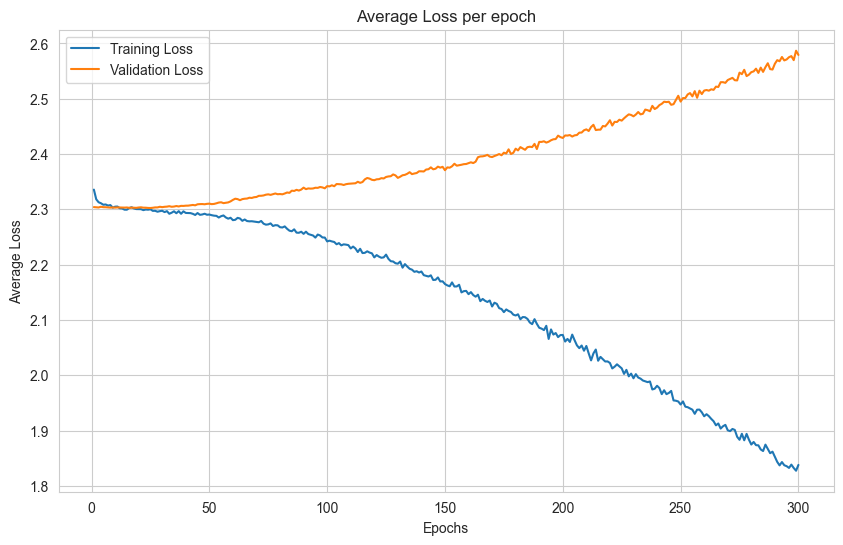

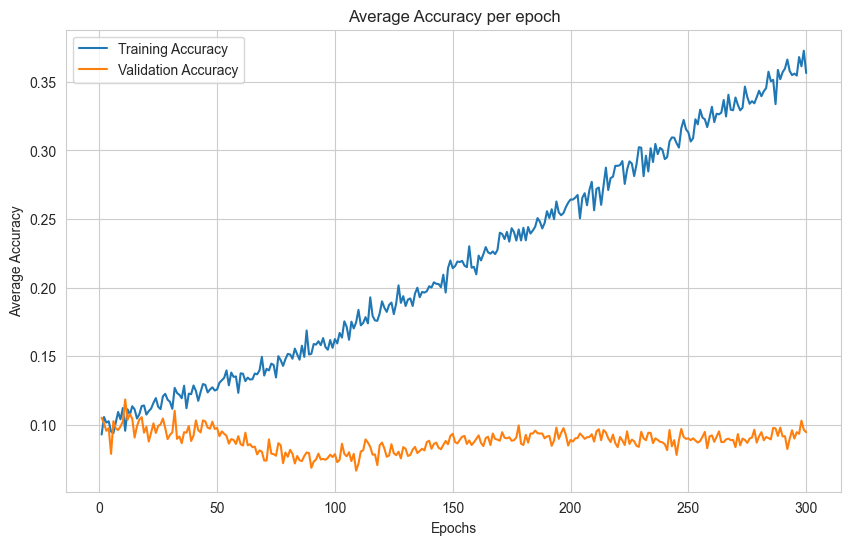

Overall Accuracy: 0.086


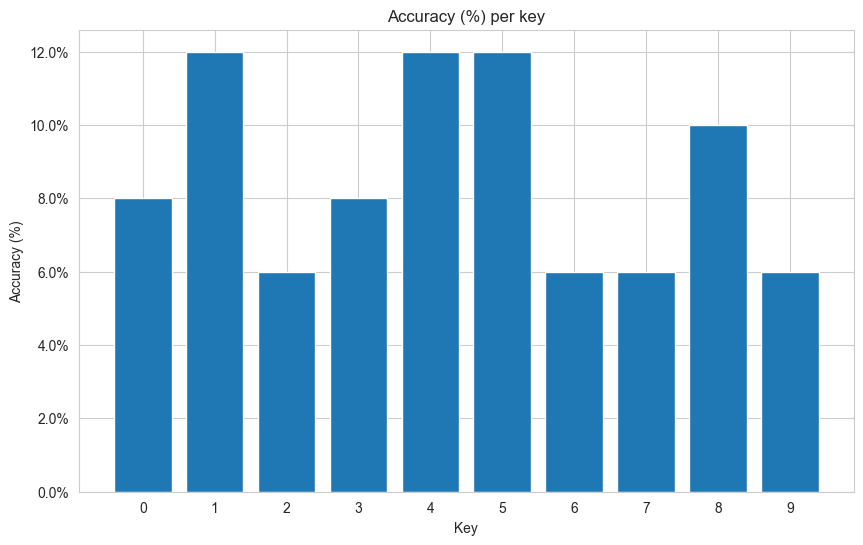

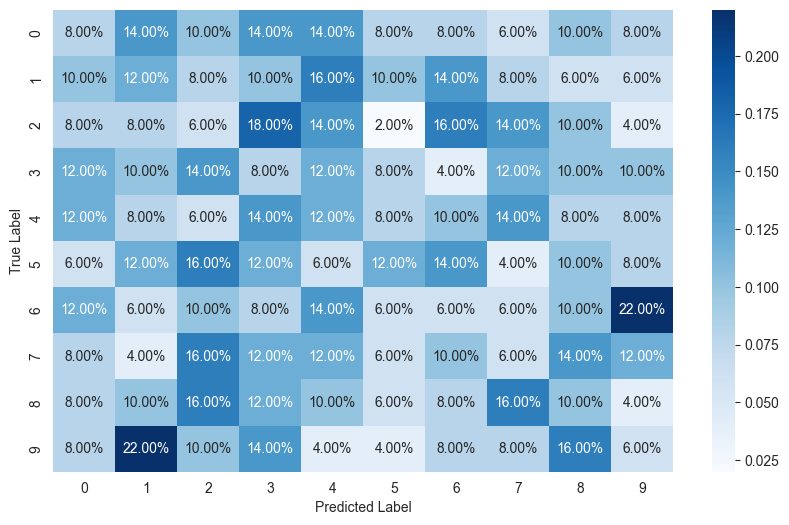

Accuracy for each key: 0: 8.0% 1: 12.0% 2: 6.0% 3: 8.0% 4: 12.0% 5: 12.0% 6: 6.0% 7: 6.0% 8: 10.0% 9: 6.0% 
              precision    recall  f1-score   support

           0       0.09      0.08      0.08        50
           1       0.11      0.12      0.12        50
           2       0.05      0.06      0.06        50
           3       0.07      0.08      0.07        50
           4       0.11      0.12      0.11        50
           5       0.17      0.12      0.14        50
           6       0.06      0.06      0.06        50
           7       0.06      0.06      0.06        50
           8       0.10      0.10      0.10        50
           9       0.07      0.06      0.06        50

    accuracy                           0.09       500
   macro avg       0.09      0.09      0.09       500
weighted avg       0.09      0.09      0.09       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 3 

In [10]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 300
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
    loss = nn.CrossEntropyLoss()
    
    if (os.path.isfile("model_final.pth")):
        model.load_state_dict(torch.load('model_final.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model_final.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()